## Experiment 2 - Advanced RAG System

Wie auch in *Experiment 1* vergleichen wir hier erneut eine komplette RAG-Pipeline, diesmal aber mit einigen **komplexeren retrieval-Schritten**. Der Ablauf ist analog `03_run_naive_rag` Skript.<br>
<br>
• Schritt 1: **Advanced RAG pipeline aufsetzen**: Erneut erstellen wir eine RAG pipeline, diesmal mit erweiterten Funktionen.<br>
<br>
• Schritt 2: **Antworten generieren**: Fragen werden durch das System geschickt.<br>
<br>
• Schritt 3: **Performance messen**: Die generierten Antworten mit den 3 Metriken der *RAG Triade* bewertet.<br>
<br>

In [1]:
# Imports & keys 

import os
os.chdir("/workspace")

from pathlib import Path
import json
import sys, subprocess, json, asyncio, nest_asyncio
nest_asyncio.apply()

import src.graph.advanced_rag as advanced_rag_graph
from src.graph.components.configuration import Configuration

from langchain_core.runnables import RunnableConfig

/usr/local/lib/python3.11/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.29.0 is exactly one major version older than the runtime version 6.31.1 at v1/aggregate.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.29.0 is exactly one major version older than the runtime version 6.31.1 at v1/base.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.29.0 is exactly one major version older than the runtime version 6.31.1 at v1/base_search.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/goo

### Was macht die Pipeline?

Im Unterschied zur *naiven* Pipeline aus Experiment 1 durchläuft eine Frage jetzt mehrere Stufen:

1. **Query Decomposition**  
   - Ein separates LLM bestimmt zunächst, ob die input Frage komplex (bzw. mehrteilig ist). 
   - Falls dies zutrifft, wird die Frage durch ein weiteres LLM in *Sub-Queries* zerlegt.

2. **Mehrstufiges Retrieval**  
   - Für die Original-Frage **und** jede weitere Sub-Query wird der Vectorstore abgefragt.  
   - Die Teilergebnisse werden mit **RRF (Reciprocal Rank Fusion)** zusammengeführt:  
     Dokumente, die in mehreren Lister häufiger bzw. weit oben erscheinen, kommen nach oben,  
     während Dokumente, die nur selten oder weit hinten auftauchen, nach unten rutschen.  

3. **Cross-Encoder Reranking (Cohere API nötig)**  
   - Die Top-N Passagen werden noch einmal mit einem Cross-Encoder sortiert,  
     um semantisch *feinere* Relevanzbewertungen zu berechnen.  

4. **Answer Generation**  
   - Frage + neu gerankte Kontexte landen im LLM, das die finale Antwort schreibt.  


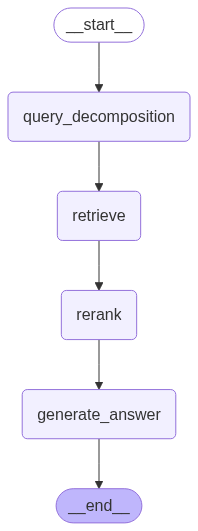

In [2]:
advanced_rag_graph.graph

In [3]:
# graph configuration 
cfg = Configuration(
    provider="anthropic", # choose the provider 
    answer_gen_model="claude-3-5-haiku-20241022", # choose the LLM gen model
    use_query_decomposition=True, # use query decomposition
    temperature=0.2, # set the temperature
    num_answers=1, # number of answers to generate 
    max_tokens=128, # maximum tokens for the answer generation (keep it short for this test)
)

run_cfg = RunnableConfig(
    configurable=cfg.model_dump()
    )

In [4]:
# run a test question
query = "welche neuen medikamente zur behandlung von psychosen gibt es und wie wirken diese?"

result = advanced_rag_graph.graph.invoke(
    {"question": query}, 
    config = run_cfg)

result

/workspace/src/graph/advanced_rag.py:157: LangChainDeprecationWarning: The class `CohereRerank` was deprecated in LangChain 0.0.30 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-cohere package and should be used instead. To use it run `pip install -U :class:`~langchain-cohere` and import as `from :class:`~langchain_cohere import CohereRerank``.
  reranker = CohereRerank(
<frozen abc>:123: ResourceWarning: unclosed <ssl.SSLSocket fd=80, family=2, type=1, proto=6, laddr=('172.31.0.2', 42384), raddr=('34.96.76.122', 443)>


{'question': 'welche neuen medikamente zur behandlung von psychosen gibt es und wie wirken diese?',
 'answers': ['Basierend auf den bereitgestellten Informationen kann ich zwei vielversprechende neue Medikamente zur Behandlung von Psychosen und Schizophrenie hervorheben:\n\n1. KarXT (Cobenfy):\nDas Medikament nutzt einen neuartigen Wirkmechanismus über Muskarinrezeptoren. Es besteht aus zwei Wirkstoffen:\n- Xanomelin: Ein M1/M4 muscarinerger Agonist, der die präsynaptische'],
 'context': [Document(metadata={'title': 'FDA lässt neuartiges Medikament zur Behandlung von Schizophrenie zu', 'rrf_score': 0.03076923076923077, 'relevance_score': 0.6437107}, page_content='Die amerikanische Arzneimittelbehörde FDA hat in der Nacht vom 26.09.2024 auf den 27.09.2024 das neuartige Medikament KarXT (Markenname Cobenfy) zur Behandlung von Schizophrenie zugelassen https://www.fda.gov/news-events/press-announcements/fda-approves-drug-new-mechanism-action-treatment-schizophrenia[I]. Die bisherigen Antip

In [20]:
state = {"question": query}
query_decomp_step = advanced_rag_graph.query_decomposition_step(state, run_cfg)
retrieval_step = advanced_rag_graph.retrieve_raw_step(state, run_cfg)
state.update(retrieval_step)
rerank_step = advanced_rag_graph.rerank_retrieved_docs(state, run_cfg)
state.update(rerank_step)

/usr/local/lib/python3.11/http/cookiejar.py:1232: ResourceWarning: unclosed <ssl.SSLSocket fd=158, family=2, type=1, proto=6, laddr=('172.31.0.2', 60498), raddr=('34.96.76.122', 443)>
  obj.items


### Antworten für das gesamte Datenset erzeugen

Wie auch im vorherigen Skript erzeugen wir für jede synthetische Frage **drei** Antworten,  
um zufällige LLM-Effekte auszugleichen und robustere Kennzahlen zu bekommen.

In [5]:
import pandas as pd
import time
from tqdm import tqdm

# load generated dataset
synth_data = pd.read_csv("synthetic_qa_pairs_mock.csv")

results = []

# iterate through the questions and generate answers
for idx in tqdm(range(len(synth_data)), desc=f"Generating Answer for Question..."):
    question = synth_data.iloc[idx]['input']
    
    try:
        # Run RAG pipeline
        start_time = time.time()
        result = advanced_rag_graph.graph.invoke(
            {"question": question}, 
            config=run_cfg
        )
        process_time = time.time() - start_time
        
        # Create base result dictionary
        result_dict = {
            'query_id': idx,
            'question': question,
            'gold_answer': synth_data.iloc[idx]['expected_output'],
            'latency': process_time,
            'context': [ctx.page_content for ctx in result['context']],
            'word_count': sum(len(ctx.page_content.split()) for ctx in result['context']),
        }
        
        # Add individual answers (if we generate more than 1)
        for ans_idx, answer in enumerate(result['answers'], 1):
            result_dict[f'answer_no_{ans_idx}'] = answer
        
        results.append(result_dict)
        
    except Exception as e:
        print(f"Error processing question {idx}: {str(e)}")
        continue

Generating Answer for Question...: 100%|██████████| 5/5 [00:41<00:00,  8.32s/it]


In [6]:
# save final results
output_path = Path('results/advanced_rag_res.json')
with open(output_path, 'w', encoding='utf-8') as f:
    json.dump(results, f, ensure_ascii=False, indent=2)

print(f"\nResults saved to {output_path}")


Results saved to results/advanced_rag_res.json


In [7]:
# load final results
results = json.load(open("results/advanced_rag_res.json", encoding="utf-8"))

/tmp/ipykernel_44009/4111221960.py:2: ResourceWarning: unclosed file <_io.TextIOWrapper name='results/advanced_rag_res.json' mode='r' encoding='utf-8'>
  results = json.load(open("results/advanced_rag_res.json", encoding="utf-8"))


### Bewertung der generierten Antworten

Und auch die Bewertung läuft eins-zu-eins wie in Experiment 1:  
Wir nutzen erneut die 3 **RAG-Triade** Kenngrößen (*Contextual Relevancy, Answer Relevancy, Faithfulness*).  
So sind die Scores vergleichbar und wir können sehen, ob die fortgeschrittene Pipeline mehr Qualität liefert.

In [8]:
from src.utils.evals import rate_dataset 

# evaluation
rated_results = asyncio.run(rate_dataset(results, model="gpt-4o-mini", max_concurrency=5))

<frozen importlib._bootstrap>:241: ResourceWarning: unclosed <ssl.SSLSocket fd=82, family=2, type=1, proto=6, laddr=('172.31.0.2', 36552), raddr=('34.96.76.122', 443)>
<frozen importlib._bootstrap>:241: ResourceWarning: unclosed <ssl.SSLSocket fd=84, family=2, type=1, proto=6, laddr=('172.31.0.2', 46996), raddr=('34.96.76.122', 443)>
<frozen importlib._bootstrap>:241: ResourceWarning: unclosed <ssl.SSLSocket fd=85, family=2, type=1, proto=6, laddr=('172.31.0.2', 55384), raddr=('34.96.76.122', 443)>
<frozen importlib._bootstrap>:241: ResourceWarning: unclosed <ssl.SSLSocket fd=87, family=2, type=1, proto=6, laddr=('172.31.0.2', 55388), raddr=('34.96.76.122', 443)>
<frozen importlib._bootstrap>:241: ResourceWarning: unclosed <ssl.SSLSocket fd=88, family=2, type=1, proto=6, laddr=('172.31.0.2', 46132), raddr=('34.96.76.122', 443)>
/usr/local/lib/python3.11/site-packages/pydantic/_internal/_config.py:323: PydanticDeprecatedSince20: Support for class-based `config` is deprecated, use Config

In [9]:
# save evaluated results
output_path = Path('results/advanced_rag_res_rated.json')
with open(output_path, 'w', encoding='utf-8') as f:
    json.dump(results, f, ensure_ascii=False, indent=2)

print(f"\nResults saved to {output_path}")


Results saved to results/advanced_rag_res_rated.json
